In [0]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, Concatenate, Dropout, LSTM, Activation
from keras.models import Model, Sequential
# import norm
from keras.constraints import unit_norm
from keras.callbacks import EarlyStopping
import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score,mean_squared_error
from numpy import array, reshape
from numpy import hstack
import matplotlib.pyplot as plt

In [0]:
from google.colab import files
uploaded = files.upload()
import io
df1 = pd.read_csv(io.BytesIO(uploaded['sample-bus.csv']))
df1.head()


Saving sample-bus.csv to sample-bus (2).csv


,date(day),day,time in seconds,holiday,peak,rain,100,132f,113t,165t,132t,113f,165f,328
0,1,Monday,19800,False,False,light,4,3,0,0,0,0,0,2
1,1,Monday,19815,False,False,light,0,3,0,0,0,0,0,0
2,1,Monday,19830,False,False,light,0,3,1,0,0,0,0,0
3,1,Monday,19845,False,False,light,2,3,1,0,0,0,0,0
4,1,Monday,19860,False,False,light,3,3,1,0,0,0,0,1


In [0]:
#create a dataframe with all training data except the target column of 100 bus interchange
X1 = df1.drop(columns=['132f','113t','165t', '132t' ,'113f','165f','328','day'])
X1.head()

,date(day),time in seconds,holiday,peak,rain,100
0,1,19800,False,False,light,4
1,1,19815,False,False,light,0
2,1,19830,False,False,light,0
3,1,19845,False,False,light,2
4,1,19860,False,False,light,3


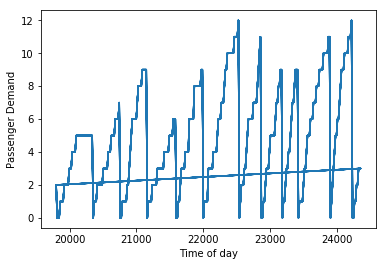

In [0]:
#visualisation of current bus data
time = np.array(X1['time in seconds'])
busdemand100 = np.array(X1['100'])
busdemand132f = np.array(df1['132f'])
busdemand113t = np.array(df1['113t'])
busdemand165t = np.array(df1['165t'])
busdemand132t = np.array(df1['132t'])
busdemand113f = np.array(df1['113f'])
busdemand165f = np.array(df1['165f'])
busdemand328 = np.array(df1['328'])
#plt.plot(time,busdemand100)
#plt.plot(time,busdemand132f)
#plt.plot(time,busdemand113t)
#plt.plot(time,busdemand165t)
#plt.plot(time,busdemand132t)
#plt.plot(time,busdemand113f)
#plt.plot(time,busdemand165f)
plt.plot(time,busdemand328)
plt.ylabel('Passenger Demand')
plt.xlabel('Time of day')
plt.show()

In [0]:
#create a column with only the target variable of bus interchange 100
y1= df1[['100']]
y1.head()

,100
0,4
1,0
2,0
3,2
4,3


In [0]:
# Categorical boolean mask
categorical_feature_mask = X1.dtypes==object

In [0]:
#testing get dummies
X3 = pd.get_dummies(X1['rain'],prefix='rain')
X3.head()

,rain_heavy,rain_light,rain_none
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [0]:
X4 = pd.get_dummies(X1['peak'],prefix='peak')
X4.head()

,peak_False,peak_True
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [0]:
X5 = pd.get_dummies(X1['holiday'],prefix='holiday')
X5.head()

,holiday_False
0,1
1,1
2,1
3,1
4,1


In [0]:
#join the new columns with get_dummies method and drop the repeated ones
X2 = X1.join([X3,X4,X5])
#X2 = X2.drop(columns=['holiday','peak','rain','date(day)','peak_False','peak_True','holiday_False'])
X2 = X2.drop(columns=['holiday','peak','rain','date(day)'])
X2.head()

,time in seconds,100,rain_heavy,rain_light,rain_none,peak_False,peak_True,holiday_False
0,19800,4,0,1,0,1,0,1
1,19815,0,0,1,0,1,0,1
2,19830,0,0,1,0,1,0,1
3,19845,2,0,1,0,1,0,1
4,19860,3,0,1,0,1,0,1


In [0]:
#train test split for testing
# split dataset, with 70% for training, and 30% for testing
train_X, X_test, train_y, y_test = train_test_split(X2,y1, test_size = 0.3)

#count the number of columns in the data
numcols = X2.shape[1]
print(numcols)

8


[[19800     4     0 ...     1     0     1]
 [19815     0     0 ...     1     0     1]
 [19830     0     0 ...     1     0     1]
 ...
 [24330     7     0 ...     0     1     1]
 [24345     8     0 ...     0     1     1]
 [24360     9     0 ...     0     1     1]]


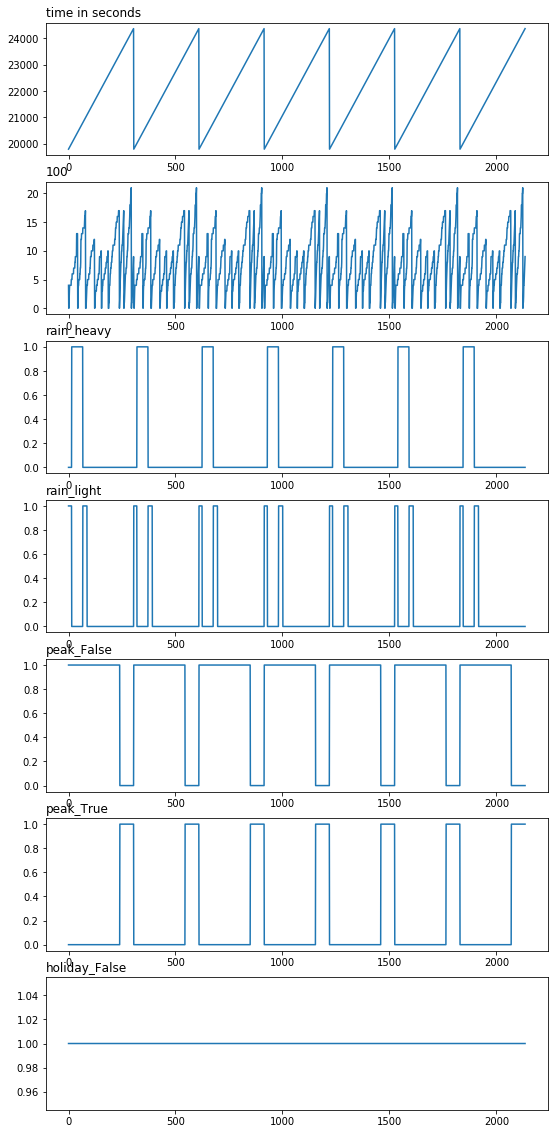

In [0]:
# visualisation of data individually
groups = [0, 1, 2, 3, 5, 6, 7]
busvalues = X2.values
print(busvalues)
i=1
plt.figure(figsize=(9,20))
for group in groups:
    plt.subplot(len(groups),1, i)
    plt.plot(busvalues[:,group])
    #place the axis titles at the left
    plt.title(X2.columns[group], loc='left')
    i +=1
plt.show()


In [0]:
''' LSTM Model'''

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#loading of the dataset
busdata = X2.values

#normalising features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X2)

#turn to supervised learning
reframed = series_to_supervised(scaled,1,1)

#remove columns not to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.000000,0.190476,0.0,1.0,0.0,1.0,0.0,0.0,0.003289
2,0.003289,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.006579
3,0.006579,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.009868
4,0.009868,0.095238,0.0,1.0,0.0,1.0,0.0,0.0,0.013158
5,0.013158,0.142857,0.0,1.0,0.0,1.0,0.0,0.0,0.016447
6,0.016447,0.190476,0.0,1.0,0.0,1.0,0.0,0.0,0.019737
7,0.019737,0.190476,0.0,1.0,0.0,1.0,0.0,0.0,0.023026
8,0.023026,0.190476,0.0,1.0,0.0,1.0,0.0,0.0,0.026316
9,0.026316,0.190476,0.0,1.0,0.0,1.0,0.0,0.0,0.029605
10,0.029605,0.190476,0.0,1.0,0.0,1.0,0.0,0.0,0.032895


In [0]:
#time_bus = reframed.values
#train test split based on the number of hours
#traininghours = 24

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['acc','mae'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


(2134, 1, 8) (2134,) (0, 1, 8) (0,)
Train on 2134 samples, validate on 0 samples
Epoch 1/50
 - 1s - loss: 0.3571 - acc: 0.0028 - mean_absolute_error: 0.3571
Epoch 2/50
 - 0s - loss: 0.1895 - acc: 0.0033 - mean_absolute_error: 0.1895
Epoch 3/50
 - 0s - loss: 0.1265 - acc: 0.0033 - mean_absolute_error: 0.1265
Epoch 4/50
 - 0s - loss: 0.0823 - acc: 0.0033 - mean_absolute_error: 0.0823
Epoch 5/50
 - 0s - loss: 0.0690 - acc: 0.0033 - mean_absolute_error: 0.0690
Epoch 6/50
 - 0s - loss: 0.0654 - acc: 0.0033 - mean_absolute_error: 0.0654
Epoch 7/50
 - 0s - loss: 0.0633 - acc: 0.0033 - mean_absolute_error: 0.0633
Epoch 8/50
 - 0s - loss: 0.0614 - acc: 0.0033 - mean_absolute_error: 0.0614
Epoch 9/50
 - 0s - loss: 0.0593 - acc: 0.0033 - mean_absolute_error: 0.0593
Epoch 10/50
 - 0s - loss: 0.0571 - acc: 0.0033 - mean_absolute_error: 0.0571
Epoch 11/50
 - 0s - loss: 0.0547 - acc: 0.0033 - mean_absolute_error: 0.0547
Epoch 12/50
 - 0s - loss: 0.0522 - acc: 0.0033 - mean_absolute_error: 0.0522
Epoc

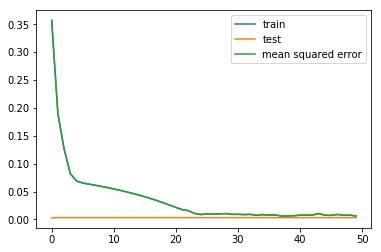

NameError: ignored

In [0]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['acc'], label='test')
plt.plot(history.history['mean_absolute_error'], label='mean squared error')
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [0]:
'''Sequential Model Attempt''' 
# design network
model = Sequential()
#LSTM input shapes need t
model.add(LSTM(50, input_shape=(.shape[1], .shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

SyntaxError: ignored

In [0]:
#inputs sequences
bus100 = ['100']

#converting to rows and columns structure
model = Sequential()
model.add(LSTM(input_shape=(1494,8), output_dim=1494, return_sequences = True))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.summary()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1494, 8), return_sequences=True, units=1494)`
  


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1494, 1494)        8981928   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1494, 1494)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 1494, 1)           1495      
_________________________________________________________________
activation_2 (Activation)    (None, 1494, 1)           0         
Total params: 8,983,423
Trainable params: 8,983,423
Non-trainable params: 0
_________________________________________________________________


In [0]:
'''Using second converted to binary dataset'''

#add layer by layer of each model
model = Sequential()

#adding the layers to the model
model.add(Dense(10,activation = 'relu', input_shape=(numcols,)))
#model.add(Embedding(2500, embed_dim,input_length = X.shape[1], dropout = 0.2))
#model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
#model.add(Dropout(0.3))
#model.add(Dense(5,activation = 'relu', input_shape=(numcols,)))
#model.add(Dropout(0.3))
#model.add(Dense(2,activation = 'relu', input_shape=(numcols,)))
#model.add(Dropout(0.3))
model.add(Dense(1))

#compile model for bus interchange 100 using mse 
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mse'])

#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=100)


startime = time.time()
#training of the model for bus inter 100
#chose for data to be passed into model 30 times
history = model.fit(train_X, train_y, epochs=800, callbacks=[early_stopping_monitor], batch_size=1000)
endtime = time.time()
print("The training process took: ", "{0:.2f}".format(endtime-startime), "seconds")


ValueError: ignored

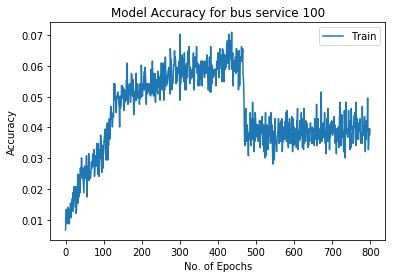

In [0]:

plt.plot(history.history['acc'])
plt.title('Model Accuracy for bus service 100')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['Train'], loc='upper right')
plt.show()

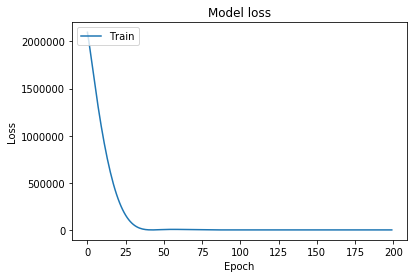

In [0]:
plt.plot(history.history['loss'])  
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [0]:
#making future predictions on bus 100
predictions = model.predict(X_test)

pred100 = pd.DataFrame(predictions)
pred100
#evaluate the model
#score = model.evaluate(X_test, y_test, verbose=1)
#print(score)
#summarize the first 5 cases
#for i in range(5):
    #print('%s => %d (expected %d)' % (train_X[i].tolist(), predictions[i], train_y[i]))


,0
0,6.471508
1,8.539449
2,9.954891
3,10.906963
4,7.062255
5,7.874798
6,7.883098
7,6.679318
8,9.942338
9,8.509348


In [0]:
print(model.get_weights())

[array([[-0.33564413, -0.4803891 , -0.19092959,  0.53440535, -0.50999564,
         0.14513183, -0.37487337,  0.39744255,  0.3243859 ,  0.17194319],
       [-0.37623367,  0.226132  , -0.21081755,  0.2176691 , -0.16949472,
         0.36235034,  0.4888939 ,  0.4936031 ,  0.13648945, -0.05927807],
       [ 0.376962  ,  0.43234116,  0.06170338, -0.25199586, -0.10324836,
         0.00874872, -0.10637368, -0.4941597 ,  0.49420372, -0.01168358],
       [-0.08713675,  0.3635947 , -0.2098999 ,  0.49831784, -0.46565947,
         0.02963807,  0.23003726, -0.3096999 , -0.19781403, -0.3807426 ],
       [ 0.2945965 ,  0.5666062 , -0.0957475 , -0.1558377 ,  0.52556187,
        -0.34557956,  0.16535074, -0.17146856,  0.24276176, -0.13124487],
       [ 0.38813537, -0.22695638, -0.35881698, -0.25576612, -0.20508671,
         0.5181588 , -0.06569911,  0.47133186, -0.36145517, -0.34594542],
       [ 0.52501124,  0.15777093, -0.4893227 ,  0.11614619, -0.40170842,
         0.55526316, -0.20014116,  0.4303842